In [107]:
from qiskit.quantum_info.operators import Operator
from qiskit import *
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import rcParams
import time
random.seed(39)

# Task 2



## Task description  <a class="anchor" id="task-description"></a>

Implement a circuit which returns |00> and |11> with equal probability.
Requirements :
- Circuit should consist only of CNOTs, RXs and RYs. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
- You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like). 
- Simulations must be done with sampling - i.e. limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

_Bonus question:
How to make sure you produce state |00>+|11> and not |00>-|11> ?_



### Table of Contents

* [How to tackle down the problem?](#tackle-down)
    * [One parameter approach](#one-parameter)
    * [Gradient descent](#gradient-descent)
    * [Estimating theta](#estimating-parameter)
* [General Solution to the task](#general-solution)
    * [Comparing results for different measurements](#different-measurements)
* [Additional information](#additional)
    * [A proof for the circuit generator](#proof)
    * [Solving the bonus question](#bonus)

# How to tackle down the problem?<a class="anchor" id="tackle-down"></a>

It is noteworthy that the problem at hand is to find a way of generating a entangled Bell state using CNOTs, RXs and RYs. This quantum state is usually obtained using the following circuit:

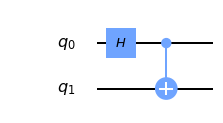

In [2]:
qc = QuantumCircuit(2) # We create a quantum circuit with 2 qubits
qc.h(0) # We apply Hadamard on the qubit-0
qc.cx(0,1) # Then we perform a CNOT operation with qubit-0 being the control and qubit-1 the objective
qc.draw(output='mpl')

Measuring the circuit presented above will output |00> and |11> with equal probability (50% of the time each). As the task was designed to be doable with basic QC knowledge, we will not approach the problem by using a universal variational form built from CNOTs, RXs and RYs. Instead, we will design a experiment we know beforehand will converge to an optimal solution using just one variational parameter to simplify the optimization algorithm (a circuit which is similar to the circuit above used to create a entangled Bell state).

## One parameter approach <a class="anchor" id="one-parameter"></a>

We draw now the circuit we will use to obtain an optimal parameter which will lead us to an output of |00> and |11> with equal probability:


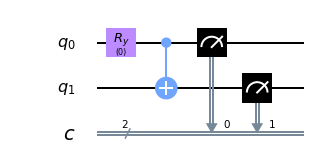

In [3]:
def generateCircuit(theta):
    circuit = QuantumCircuit(2,2) 
    circuit.ry(theta,0) 
    circuit.cx(0,1)
    circuit.measure([0,1],[0,1])
    return circuit

generateCircuit(0).draw(output='mpl')

#### Is there a parameter which will lead us to our objective result using the circuit above?

The answer to this question is: yes, there is a parameter $\theta =\frac{\pi}{2}$ which will cause our circuit to output |00> and |11> with equal probability. One could generate some outputs in order to get a feeling of what the circuit is doing. By using a simulator we will carry out some measurements to check whether or not our hypothesis was leading us to the right way: 

In [4]:
circuit = generateCircuit(np.pi/2)

results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=1000).result().get_counts()

print(results)

{'11': 484, '00': 516}


The experimental result obtained above should encaurages us to use the circuit in order to solve the task. Nevertheless, a formal proof can be obtained to confirm our approach. At the end of this notebook a formal proof is presented.  

## Gradient descent  <a class="anchor" id="gradient-descent"></a>

We know proceed to implement an optimization algorithm to find out an optimal value of theta which will output |00> and |11> with equal probability. In order to do this we have to state a function which we will minimize based on the performance of our measurements on the circuit. A simple way to estimate how far is our output from the objective is to estimate the expression of our vector in a 4-dimensional Hilbert space and substract it from the objective vector. As we want just values |00> and |11> to output we will not care about phases. This idea goes as follows:

$$ 
Objective: V = \begin{pmatrix} \frac{1}{\sqrt2} \\ 0 \\ 0 \\ \frac{1}{\sqrt2} \end{pmatrix} = \frac{ | 00 \rangle +  | 11 \rangle }{\sqrt2}
$$

$$ 
Current: C({\theta}) = \begin{pmatrix} a \\ b \\ c \\ d \end{pmatrix} = a | 00 \rangle + b | 01 \rangle + c | 10 \rangle + d | 11 \rangle
$$

So we want to minimize:
$$
 F(\theta) = \left\lVert V - C(\theta) \right\rVert_{2}
$$

Note that the current vector $C(\theta)$ can be obtained experimentally using the Born's law.

### Gradient descent formulae

The steps we will follow to carry out the gradient descent algorithm are portrayed below:

$$
\theta := \theta - \alpha \frac{\partial F(\theta)}{\partial \theta} 
$$

where $\alpha$ is the learning rate. $\frac{\partial F}{\partial \theta}$ will be estimated using the finite difference method:

$$
\frac{\partial F}{\partial \theta}  = \frac{F(\theta + h) - F(\theta)}{h}
$$
where $h$ is a small value.

### Function evaluation

We will now present a function which will take a $\theta$ parameter and calculate the value of the function $F$ given above (it will also receive as a parameter the number of measurements it will have to carry out to estimate the output vector). 


In [5]:
def evaluateFunction(theta, number_measurements):
    
    results = execute(generateCircuit(theta), backend=BasicAer.get_backend('qasm_simulator'), 
                      shots=number_measurements).result().get_counts()
    
    c_vector = np.array([0,0,0,0])
    c_vector[0] = results.get("00", 0)
    c_vector[1] = results.get("01", 0)
    c_vector[2] = results.get("10", 0)
    c_vector[3] = results.get("11", 0)
    c_vector = c_vector / np.linalg.norm(c_vector,ord=2)

    objective_vector = np.array([1/np.sqrt(2), 0,0, 1/np.sqrt(2)])
    
    return np.linalg.norm(objective_vector - c_vector, ord=2)

## Estimating theta  <a class="anchor" id="estimating-parameter"></a>

Once the evaluation function has been obtained, we can proceed to implement the gradient descent algorithm. First we will define the variables used:

In [6]:
learning_rate = 0.05 # Learning rate or alpha value used for gradient descent
max_iteration = 1000 # Max number of iteration to avoid infinite looping
precision = 0.1 # Precision, we want to get as close to zero when evaluating F(θ) as possible.
measurements = 1000 # Number of measurements of the circuit
theta = random.random() # Initialize theta as a random value
h_value = 0.01 # h value used in the finite difference method to estimate the derivative of F

function_value = evaluateFunction(theta, measurements) # Calculate the initial estimated value for the initial parameter

print("Initial theta: ", theta)
print("Initial function value: ", function_value)

Initial theta:  0.20985124453651727
Initial function value:  0.7569688042801143


We will also keep track of all values of the function obtained and all angles used as parameters:

In [7]:
vector_thetas = [theta] # List of all values of thetas calculated
vector_function_values = [function_value] # List of all values of the function obtained

We are now ready to solve the task using the gradient descent method:

In [8]:
iteration = 0 
vector_iteration = [iteration] # List of indexes of iterations

# We will keep iterating until the loss function evaluation is less than the precision required or the 
# number of max iterations allowed is overpassed
while np.linalg.norm(function_value) > precision and iteration < max_iteration: 
    
    # Calculate the derivative using the finite difference method
    finite_difference = (evaluateFunction(theta + h_value, measurements) - evaluateFunction(theta, measurements)) / h_value
    
    # New value of theta is calculated
    theta = theta - learning_rate * finite_difference
    function_value = evaluateFunction(theta, measurements)
    
    # Save all information related to the execution of this iteration
    vector_thetas.append(theta)
    vector_function_values.append(function_value)
    iteration += 1
    vector_iteration.append(iteration)

In [9]:
print("Optimal theta: ", np.pi/2)
print("Estimation theta:", theta)

Optimal theta:  1.5707963267948966
Estimation theta: 1.4627512752590255


We can also plot all the information related to the iteration process. The following graphical representation shows the evolution of the parameter over time with a blue line, we also introduced an horizontal line with the optimal value of the angle:

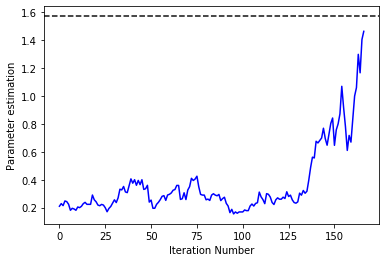

In [10]:
plt.plot(vector_iteration,vector_thetas,color='#0000ff')
plt.axhline(y=np.pi/2,color='#0F0F0F',ls='--')
plt.xlabel('Iteration Number')
plt.ylabel('Parameter estimation')
plt.show()

Moreover, we can plot the data related to the loss function. Here we represent the evolution of the loss function with a red line:

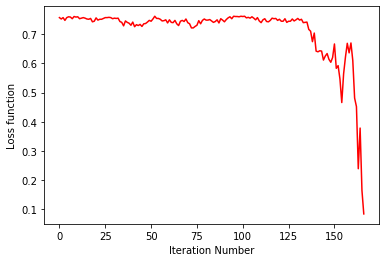

In [11]:
plt.plot(vector_iteration,vector_function_values,color='#ff0000')
plt.xlabel('Iteration Number')
plt.ylabel('Loss function')
plt.show()

# General Solution to the task <a class="anchor" id="general-solution"></a>

The circuit presented above solves the problem of designing a circuit which outputs |00> and |11> with equal probability using just CNOTs, RYs and RXs gates. We started with a parameter randomly generated and through an optimization process we obtain an optimal parameter theta which makes the circuit behaves as expected. 

In order to compare the algorithm using different number of measurements we present now a more parametrized and compact form of the solution:


In [12]:
def simpleCircuitGenerator(parameters):
    theta = parameters[0]
    circuit = QuantumCircuit(2,2) 
    circuit.ry(theta,0) 
    circuit.cx(0,1)
    circuit.measure([0,1],[0,1])
    return circuit

In [13]:
def simpleLossFunction(circuitGenerator, parameters, measurements):
    results = execute(circuitGenerator(parameters), backend=BasicAer.get_backend('qasm_simulator'), 
                      shots=measurements).result().get_counts()
    c_vector = np.array([0,0,0,0])
    c_vector[0] = results.get("00", 0)
    c_vector[1] = results.get("01", 0)
    c_vector[2] = results.get("10", 0)
    c_vector[3] = results.get("11", 0)
    c_vector = c_vector / np.linalg.norm(c_vector,ord=2)
    objective_vector = np.array([1/np.sqrt(2), 0,0, 1/np.sqrt(2)])
    return np.linalg.norm(objective_vector - c_vector, ord=2)

In [14]:
class VectorEstimation:
    
    def __init__(self, circuitGenerator, initial_parameters, lossFunction, precision = 0.1, 
                 learning_rate = 0.05, max_iteration = 1000, measurements = 1000, h_value = 0.01):
        
        self.circuitGenerator = circuitGenerator
        self.lossFunction = lossFunction
        self.initial_parameters = initial_parameters
        self.precision = precision
        self.learning_rate = learning_rate
        self.max_iteration = max_iteration
        self.measurements = measurements
        self.h_value = h_value
        self.optimal_parameters = None
        self.vector_parameters = []
        self.vector_loss_values = []
        self.vector_iteration = []
        self.iteration = 0 
        
    def estimate(self):
        
        loss_value = self.lossFunction(self.circuitGenerator, self.initial_parameters, self.measurements)
        current_parameters = self.initial_parameters
        
        self.vector_parameters.append(current_parameters)
        self.vector_iteration.append(self.iteration)
        self.vector_loss_values.append(loss_value)
        
        while np.linalg.norm(loss_value) > self.precision and self.iteration < self.max_iteration:
            new_parameters = current_parameters.copy()
            for index,parameter in enumerate(current_parameters):
                new_parameters[index] = self.__calculateFiniteDifference(index, current_parameters)
                
            for index,derivative in enumerate(new_parameters):
                current_parameters[index] = current_parameters[index] - self.learning_rate * derivative
            
            loss_value = self.lossFunction(self.circuitGenerator, current_parameters, self.measurements)
            
            self.iteration += 1
            self.vector_parameters.append(current_parameters.copy())
            self.vector_iteration.append(self.iteration)
            self.vector_loss_values.append(loss_value)
        
        self.optimal_parameters = current_parameters
        return self.optimal_parameters, loss_value
    
    def __calculateFiniteDifference(self, index, current_parameters):
        parameters = current_parameters.copy()
        parameters[index] += self.h_value
        finite_difference = (self.lossFunction(self.circuitGenerator, parameters, self.measurements) 
                             - self.lossFunction(self.circuitGenerator, current_parameters, self.measurements)) / h_value
        return finite_difference
    
    def getVectorParameters(self):
        return self.vector_parameters
    
    def getVectorLossValues(self):
        return self.vector_loss_values
    
    def getVectorIterationValues(self):
        return self.vector_iteration
    
    def getOptimalParameters(self):
        return self.optimal_parameters
    

Now we can proceed to use our VectorEstimation class to carry out optimization using a generic circuit generator and a loss function which leads to a minimum value in the objective vector state. Also, parameters are now highly configurable and we can repeat the experiment with different number of measurements (note that the parameters of the circuit generator are also generic now and they are given as a list):

In [15]:
task2solution = VectorEstimation(circuitGenerator = simpleCircuitGenerator, lossFunction = simpleLossFunction, 
                                 initial_parameters = [random.random()], measurements = 1000)

In [16]:
task2solution.estimate()

([1.6071374028096204], 0.0)

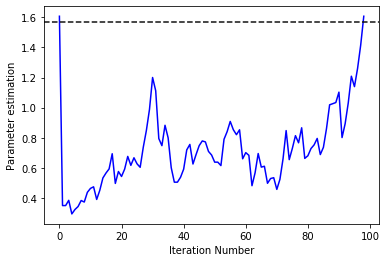

In [17]:
plt.plot(task2solution.getVectorIterationValues(),task2solution.getVectorParameters(),color='#0000ff')
plt.axhline(y=np.pi/2,color='#0F0F0F',ls='--')
plt.xlabel('Iteration Number')
plt.ylabel('Parameter estimation')
plt.show()

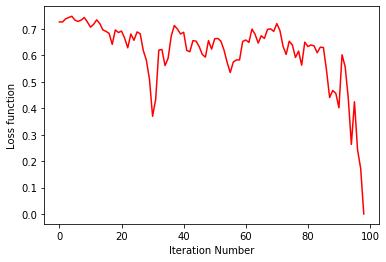

In [18]:
plt.plot(task2solution.getVectorIterationValues(),task2solution.getVectorLossValues(),color='#ff0000')
plt.xlabel('Iteration Number')
plt.ylabel('Loss function')
plt.show()

### Comparing results for different measurements <a class="anchor" id="different-measurements"></a>

It is important when comparing the performance of different measurements to take into account other parameters such as precision, learning rate and max iteration. We will keep constant these values with the default values used throughout the notebook.

We measure now the time taken for the algorithm to estimate the parameters depending on the number of measurements:

In [19]:
vector_measurements = [1, 10, 100, 1000]
taskList = []

for measurements in vector_measurements:
    start = time.time()
    print("Start measurement [", measurements, "]")
    task2solution = VectorEstimation(circuitGenerator = simpleCircuitGenerator, lossFunction = simpleLossFunction, 
                                 initial_parameters = [random.random()], measurements = measurements)
    task2solution.estimate()
    end = time.time()
    print(" \t -> Finished. Total time: ", end-start)
    taskList.append(task2solution)
    

Start measurement [ 1 ]
 	 -> Finished. Total time:  27.551057815551758
Start measurement [ 10 ]
 	 -> Finished. Total time:  0.28403449058532715
Start measurement [ 100 ]
 	 -> Finished. Total time:  0.49819183349609375
Start measurement [ 1000 ]
 	 -> Finished. Total time:  1.7640447616577148


It might seem strange that the time taken with only one measurement is the higher. Nevertheless, this is completely reasonable as when performing just one sampling the estimation of the current vector is no accurate at all. For this reason, the algorithms loops randomly until max iteration is overpassed. 

To analyse the results we will check what were the optimal parameters obtained by each experiment:

In [20]:
print("Measurement [1]: ", taskList[0].getOptimalParameters())
print("Measurement [10]: ", taskList[1].getOptimalParameters())
print("Measurement [100]: ", taskList[2].getOptimalParameters())
print("Measurement [1000]: ", taskList[3].getOptimalParameters())
print("Possible optimal: ", np.pi/2)

Measurement [1]:  [0.19506031439111238]
Measurement [10]:  [-1.6233053311926233]
Measurement [100]:  [1.5205730214911994]
Measurement [1000]:  [1.5331415298264135]
Possible optimal:  1.5707963267948966


A remarkable observation is that though $\frac{\pi}{2}$ is a feasible optimal solution, $\frac{-\pi}{2}$ is also an optimal solution. One can find infinitely many solutions since the parametric rotational gates can be expressed as matrices which components are periodic functions. As it was mentioned before, the worst performance is obtained when measuring just one time for each iteration since no information at all is retrieved from the quantum system. 
As it might be expected by a frequentist probability approach, the frequency estimation of the components of the vector converge to their real value. So, the more measurements are carried out, the greater the precision of the experiment itself. 


# Additional Information <a class="anchor" id="additional"></a>

## A proof for the circuit generator <a class="anchor" id="proof"></a>

A proof is easy to obtain just by performing the appropiate calculations. Suppose a two qubits quantum circuit is provided, with the following set up:

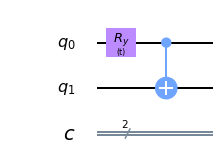

In [25]:
qc = QuantumCircuit(2,2) 
qc.ry('t', 0)
qc.cx(0,1) 
qc.draw(output='mpl')

We can therefore obtain the unitary transformation related to the quantum system above:


In [28]:
job = execute(qc, Aer.get_backend('unitary_simulator'))
result = job.result()
print(result.get_unitary(qc, decimals=3))

[[ 0.707+0.j  0.707+0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.707+0.j -0.707+0.j]
 [ 0.   +0.j  0.   +0.j  0.707+0.j  0.707+0.j]
 [ 0.707+0.j -0.707+0.j  0.   +0.j  0.   +0.j]]


Now we recall how entangled Bell pairs were normally generated:

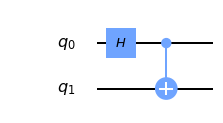

In [109]:
qc = QuantumCircuit(2) 
qc.h(0) 
qc.cx(0,1) 
qc.draw(output='mpl')

Performing the same operations as before:

In [110]:
job = execute(qc, Aer.get_backend('unitary_simulator'))
result = job.result()
print(result.get_unitary(qc, decimals=3))

[[ 0.707+0.j  0.707+0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.707+0.j -0.707+0.j]
 [ 0.   +0.j  0.   +0.j  0.707+0.j  0.707+0.j]
 [ 0.707+0.j -0.707+0.j  0.   +0.j  0.   +0.j]]


Indeed, we have that for both systems:
$$ S_{1} |00 \rangle \mapsto  \frac{|00\rangle + |11\rangle}{\sqrt2}  $$
$$ S_{2} |00 \rangle \mapsto  \frac{|00\rangle + |11\rangle}{\sqrt2}  $$


## Solving the bonus question <a class="anchor" id="bonus"></a>

Looking carefully to the calculations made during last section one is sure that the state produced is indeed $ \frac{|00\rangle + |11\rangle}{\sqrt2}  $ and not  $ \frac{|00\rangle - |11\rangle}{\sqrt2}  $. What is more, this calculation could be reproduced if someone wants to know whether or not the state produced by its system is the objective one. To carry out this operations you just have to substitute your parameter value and perform the calculations. 

However, there are times when the matrix is big enough or when no calculations can be made due to an exponential growth in the circuit. When this is the case, another techniques must be used to make sure your state was the objective one. We will now carefully compare the two possible states of the bonus question: $ v_{1} = \frac{|00\rangle + |11\rangle}{\sqrt2}  $ and $ v_{2} = \frac{|00\rangle - |11\rangle}{\sqrt2}  $. The only difference between them is the relative phase. Moreover, they are two of the four entangled pair Bell states. If we look at the unitary matrix of $S_{2}$ and check how it maps the computational basis for two qubits we will end up with:

$$ S_{2} |00 \rangle \mapsto  \frac{|00\rangle + |11\rangle}{\sqrt2}  $$
$$ S_{2} |11 \rangle \mapsto  \frac{|00\rangle - |11\rangle}{\sqrt2}  $$

Then, as every quantum circuit is composed of unitary operations we could find out its inverse. Performing the inverse operations will led us to $|00\rangle$ whenever there is no phase and to $|11\rangle$ if there is a relative phase. 

So, just to recap, we have two different ways: checking the unitary operations performed or calculating the inverse operations and performing them. We will now use the second method to distinguish Bell states:

In [149]:
def measure_untangle(shots,phase=False):
    circuit_bell = QuantumCircuit(2,2)
    if phase:
        circuit_bell.x(0)
        circuit_bell.x(1)
    
    # Create the Bell pair
    circuit_bell.h(0)
    circuit_bell.cx(0,1)
    
    # Perform the inverse operation
    inverse_unitary_matrix = np.linalg.inv(np.matrix([[ 1/np.sqrt(2),  1/np.sqrt(2),  0,  0], 
                                                      [ 0,  0 , 1/np.sqrt(2), -1/np.sqrt(2)],
                                                      [ 0,  0,  1/np.sqrt(2) , 1/np.sqrt(2)],
                                                      [ 1/np.sqrt(2), -1/np.sqrt(2),  0,  0]]))
    inverse_gate = Operator(inverse_unitary_matrix)
    circuit_bell.unitary(inverse_gate, [0, 1], label='untangle_bell')
    circuit_bell.measure([0,1],[0,1])
    return execute(circuit_bell, backend=BasicAer.get_backend('qasm_simulator'), shots=shots).result().get_counts()

Now we can perform the operations described above:

In [150]:
print("With phase:", measure_untangle(phase=True,shots=1000))
print("Without phase:", measure_untangle(phase=False, shots=1000))

With phase: {'11': 1000}
Without phase: {'00': 1000}
